 * **이 튜토리얼에서 타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 생존여부를 예측하는 모델을 생성할 것입니다.**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅
# 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하는 방법

import missingno as msno
# library for the exploratory visualization of missing data.

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# 브라우저 내부(inline)에 바로 그려지도록 해주는 코드

### **프로세스 정리**
1. 데이터셋 확인 - null data 확인 후 수정              

2. 탐색적 데이터 분석(eda) - 여러 feature들을 개별적으로 분석하고 feature들간의 상관관계 확인    
여러 시각화 툴을 사용하여 insight 얻음             

3. feature engineering - 모델의 성능을 높일 수 있도록 feature들을 engineering함     
one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 한다.          

4. model 만들기 - sklearn을 사용해 모델을 만든다.       
딥러닝을 위해 tensorflow, pytorch 등을 사용할 수도 있다.                      

5. 모델 학습 및 예측 - trainset을 가지고 모델을 학습시킨 후, testset을 가지고 prediction 함.        

6. 모델 평가 

## 1. Dataset  확인
---

In [3]:
df_train = pd.read_csv('C:/Users/JIEUN OH/OneDrive/바탕 화면/Kaggle_data/Titanic/train.csv')
df_test = pd.read_csv('C:/Users/JIEUN OH/OneDrive/바탕 화면/Kaggle_data/Titanic/test.csv')

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


우리가 다루는 문제에서 feature 은 Pclass, Age, SibSp, Parch, Fare이며,                    
**예측하려는 target label은 Survived이다.**

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Survived: 생존여부 (0,1)
- Pclass: 티켓의 클래스 (1: 1st class, 2: 2nd class, 3: 3rd class)
- SibSp: 함께 탑승한 형제와 배우자의 수
- Parch: 함께 탑승한 부모, 아이의 수
- Fare: 탑승료

In [8]:
# 각 연속형 feature의 통계치 반환
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 1.1 Null data check
---

In [13]:
#  각 column별 Null data 비율 구하기
for col in df_train.columns:
    msg = 'column {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum()/df_train[col].shape[0])) 
    print(msg)

column PassengerId	 Percent of NaN value: 0.00%
column   Survived	 Percent of NaN value: 0.00%
column     Pclass	 Percent of NaN value: 0.00%
column       Name	 Percent of NaN value: 0.00%
column        Sex	 Percent of NaN value: 0.00%
column        Age	 Percent of NaN value: 19.87%
column      SibSp	 Percent of NaN value: 0.00%
column      Parch	 Percent of NaN value: 0.00%
column     Ticket	 Percent of NaN value: 0.00%
column       Fare	 Percent of NaN value: 0.00%
column      Cabin	 Percent of NaN value: 77.10%
column   Embarked	 Percent of NaN value: 0.22%


In [15]:
for col in df_test.columns:
    msg = 'column {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column PassengerId	 Percent of NaN value: 0.00%
column     Pclass	 Percent of NaN value: 0.00%
column       Name	 Percent of NaN value: 0.00%
column        Sex	 Percent of NaN value: 0.00%
column        Age	 Percent of NaN value: 42.34%
column      SibSp	 Percent of NaN value: 0.00%
column      Parch	 Percent of NaN value: 0.00%
column     Ticket	 Percent of NaN value: 0.00%
column       Fare	 Percent of NaN value: 0.00%
column      Cabin	 Percent of NaN value: 164.35%
column   Embarked	 Percent of NaN value: 0.48%


-> train, test set 에서 Age, Cabin, Embarked 에 null이 존재한다.
- MANO라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있다.
   - msno.matrix: null data를 matrix 형태로 시각화

<AxesSubplot:>

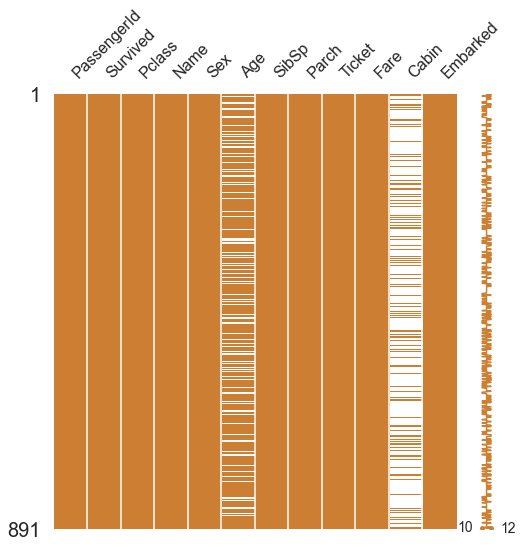

In [18]:
msno.matrix(df=df_train, figsize=(8,8), color=(0.8,0.5,0.2))

<AxesSubplot:>

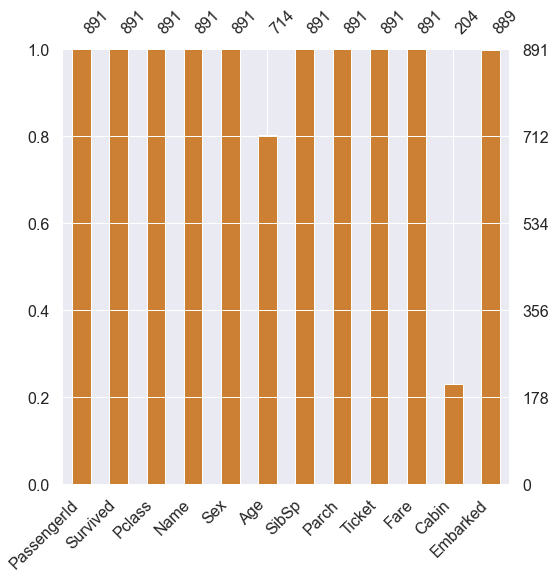

In [19]:
msno.bar(df=df_train, figsize=(8,8), color=(0.8, 0.5, 0.2))

### 1.2 Target label 확인
---
- **target lablel이 어떤 distribution을 가지고 있는지 확인해야함**
- 지금 같은 binary classification 문제의 경우 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라 질 수 있다.

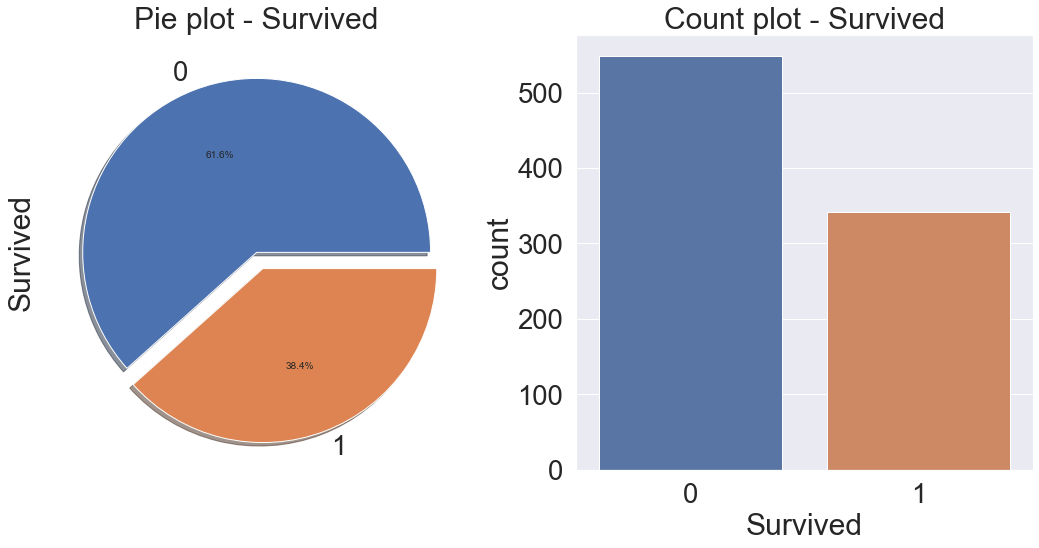

In [62]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
# subplot 2개를 한꺼번에 잡음

df_train.Survived.value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
#ax[0].set_ylabel('')

sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

- countplot: A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable. The basic API and options are identical to those for barplot()
 

-> 죽은 사람이 더 많다.38.4%가 살아남았다.                
->  target label의 분포가 나름 균일(balanced)하다. 불균일할 경우 조정이 필요하다.


## 2. Exploratory data analysis
---
### 2.1 Pclass
---
- Pclass 는 ordinal 서수형 데이터이다. 카테고리이면서 순서가 있는 데이터 타입이다.
- 먼저 Pclass에 따른 생존률의 차이를 살펴보자 -> pandas df에서는 groupby를 사용하면 쉽게 할 수 있다. 또한 pivot이라는 메소드도 있다.
- count()를 하면 각 class에 몇명이 있는지 확인할 수 있으며,  sum()을 하면 216명중 생존한(survived=1) 사람의 총합을 주게 된다.

In [29]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


- groupby(as_index=True): 이 그룹을 인덱스로 지정할 것이니 여부. False하면 인덱스가 따로 지정되어 출력됨

In [30]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count().sum()

Survived    891
dtype: int64

- pandas의 crosstab을 사용하면 좀 더 위 과정을 수월하게 볼 수 있다.

In [65]:
pd.crosstab(df_train.Pclass, df_train.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


- pandas.crosstab(margins=True): Default False임. True 하면 row/column margin(subtotal)이 각각 추가된다.

- grouped 객체에 mean()을 하게 되면 각 클래스별 생존률을 얻을 수 있다. 

In [74]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived'),

(        Survived
 Pclass          
 3       0.242363
 2       0.472826
 1       0.629630,)

<AxesSubplot:xlabel='Pclass'>

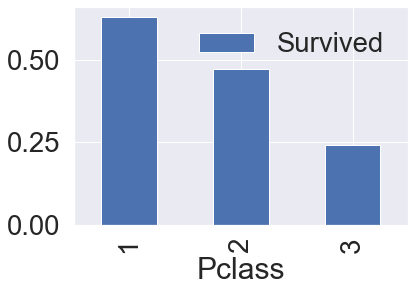

In [69]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

-> Pclass가 좋을수록 생존률이 높다.
- 좀 더 보기 쉽게 그래프를 그려보겠다. seaborn의 countplot을 이용하면 특정 label에 따른 개수를 확인해볼 수 있다.

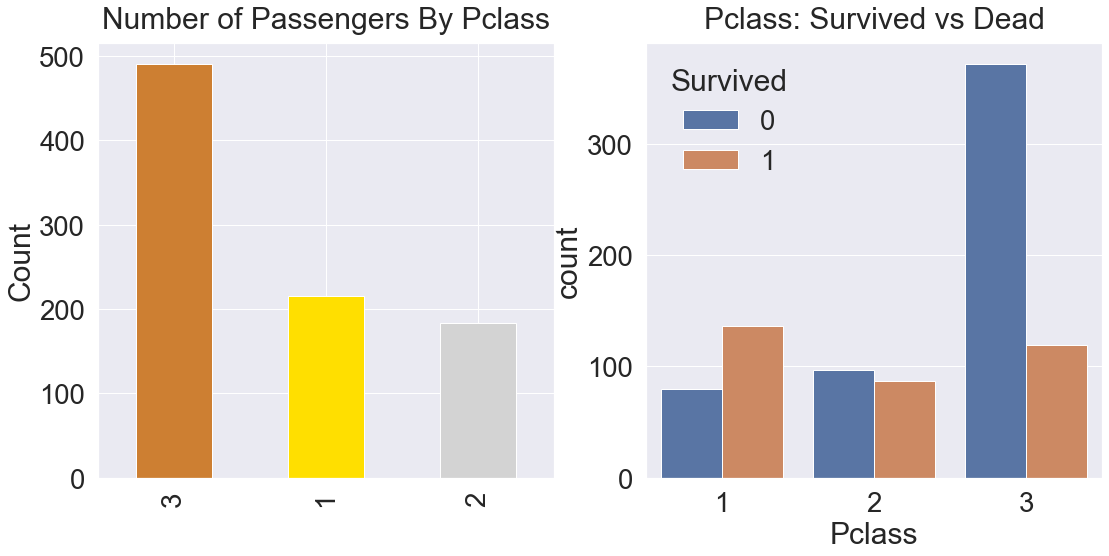

In [75]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18,8))
df_train.Pclass.value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')

sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
# x, y, huenames of variables in data or vector data, optional
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

-> 클래스가 높을수록 생존 확률이 높다.        
=> 생존에 Pclass가 큰 영향을 미친다고 생각할 수 있다. 나중에 모델을 세울 때 이 feature을 사용하는 것이 좋을 것이라 판단할 수 있다.

### 2.2 Sex
---
- 이번에는 성별로 생존률이 어떻게 달라지는지 확인해보겠다.
- 마찬가지로 pandas groupby와 seaborn countplot을 사용해서 시각화해보겠다.

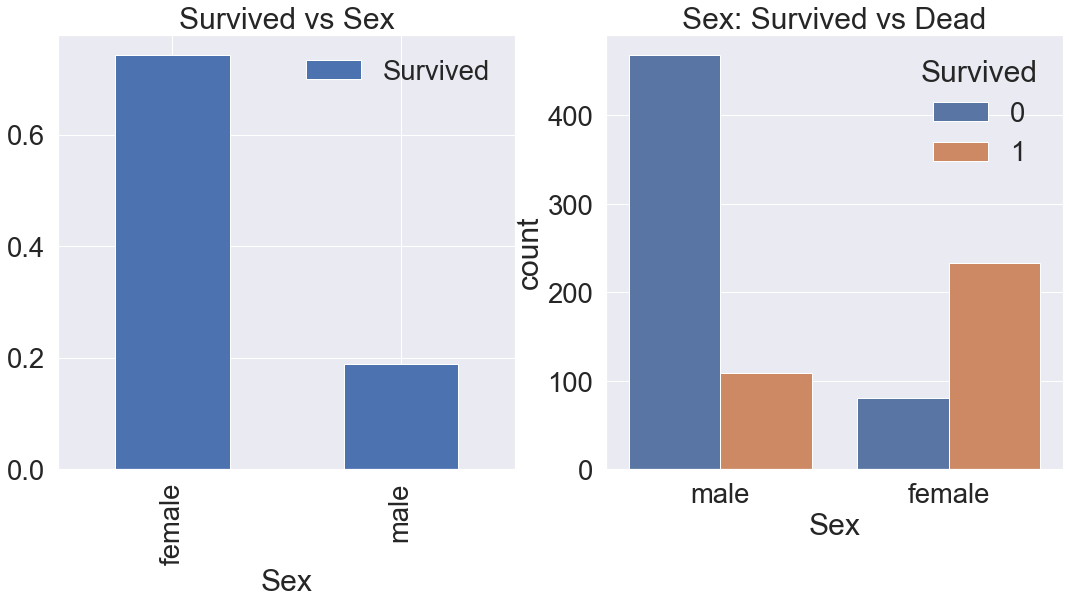

In [9]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

->  여성이 생존할 확률이 더 높다.

In [12]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [15]:
pd.crosstab(df_train.Sex, df_train.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


-> Pclass와 마찬가지로 Sex도 예측 모델에 쓰일 중요한 feature임을 알 수 있다.

### 2.3 Both Sex and Pclass
---
- 이번에는 Sex, Pclass 두 가지에 관하여 생존이 어떻게 달라지는지 확인해보자.
- seaborn의 factorplot을 이용하면, 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있다.

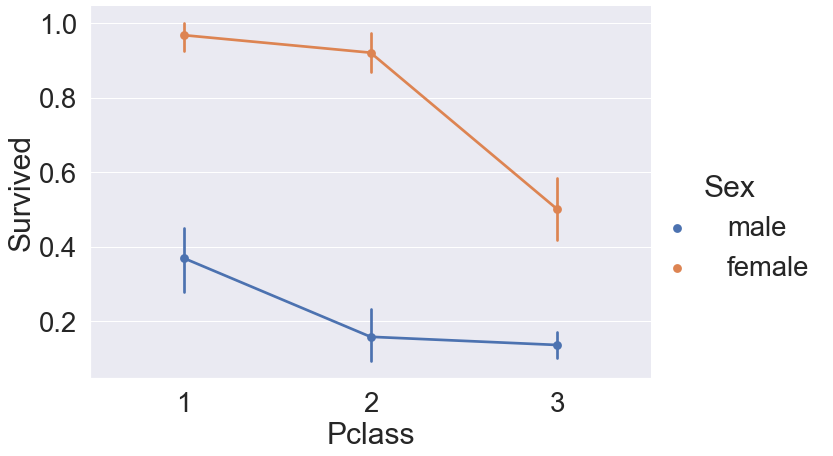

In [16]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect=1.5)

-> 모든 클래스에서 여성이 살 확률이 남성보다 높은 것을 알 수 있다.                 
-> 성별 상관없이 클래스가 높을수록 살 확률이 높다.

**seaborn.factorplot()**       
- draw a categorical plot onto a FacetGrid         
- hue: (optional)This parameter take column name for color encoding
- aspect : (optional) This parameter take float value, Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.      
https://www.geeksforgeeks.org/python-seaborn-factorplot-method/

- 위 그래프는 hue 대신 column으로 하면 아래와 같아진다.

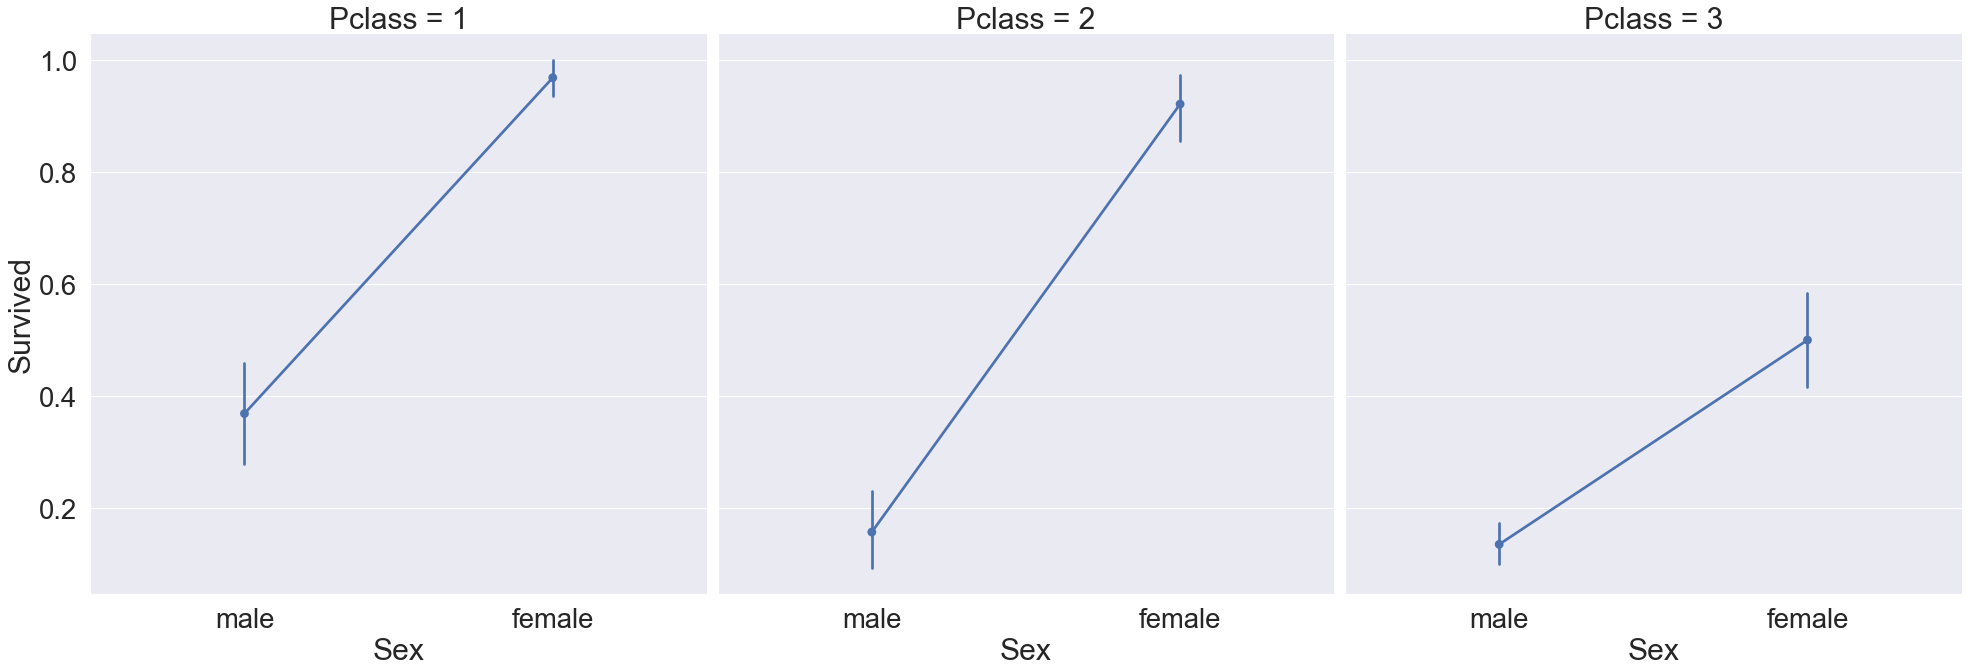

In [17]:
sns.factorplot(x='Sex', y='Survived', col='Pclass',
              data=df_train, satureation=.5, size=9, aspect=1)

### 2.4 Age
---
- 이번에는 Age feature를 살펴보겠다.

In [4]:
print('제일 나이 많은 탑승객: {:.1f} Years'.format(df_train.Age.max()))
print('제일 나이 어린 탑승객: {:.1f} Years'.format(df_train.Age.min()))
print('탑승객 평균 나이: {:.1f} Years'.format(df_train.Age.mean()))

제일 나이 많은 탑승객: 80.0 Years
제일 나이 어린 탑승객: 0.4 Years
탑승객 평균 나이: 29.7 Years


- 생존에 따른 Age의 histogram을 그려보겠다.

**seaborn.kdeplot**       
- represents the data using a continuous probability density curve in one or more dimensions
- ax: pro-existing axes for the plot 

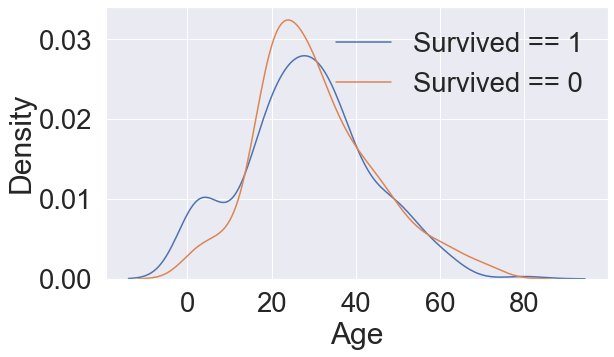

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9,5))
sns.kdeplot(df_train[df_train.Survived == 1].Age, ax=ax)
sns.kdeplot(df_train[df_train.Survived == 0].Age, ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

-> 생존자 분포가 왼쪽으로 치우쳐 있는 것으로 보아 생존자 중 나이가 어린 경우가 많다. 

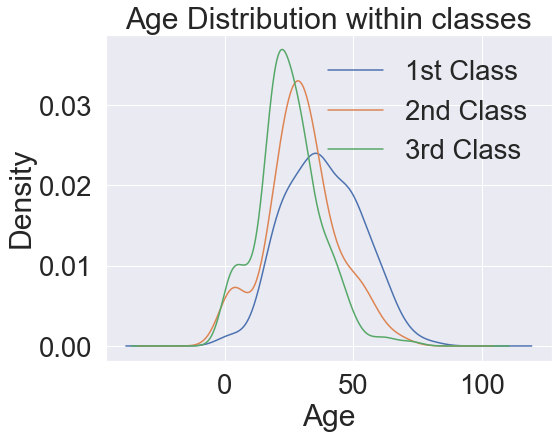

In [9]:
# Age distribution within classes
plt.figure(figsize=(8, 6))
df_train.Age[df_train.Pclass == 1].plot(kind='kde')
df_train.Age[df_train.Pclass == 2].plot(kind='kde')
df_train.Age[df_train.Pclass == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

-> Class가 높을 수록 나이 많은 사람의 비중이 커짐    

- 나이대가 변하면서 생존률이 어떻게 되는지 보자      
나이 범위를 점점 넓혀가며, 생존률이 어떻게 되는지 보기

In [11]:
df_train[df_train.Age < 32].Survived.sum()

0      0
2      1
7      0
8      1
9      1
      ..
883    0
884    0
886    0
887    1
889    1
Name: Survived, Length: 428, dtype: int64

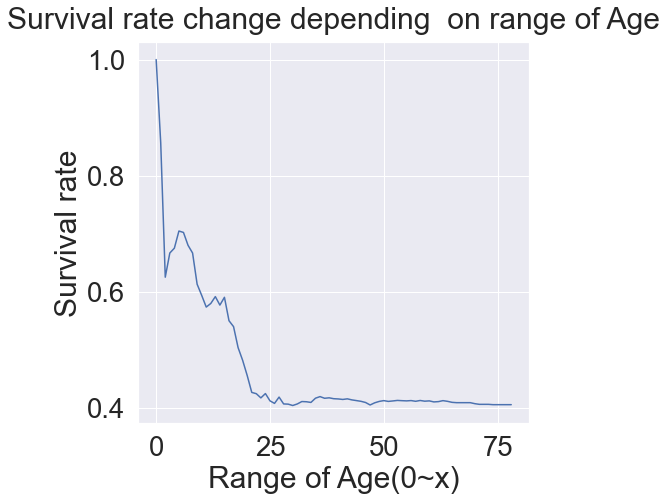

In [12]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(
        df_train[df_train.Age < i].Survived.sum() / len(df_train[df_train.Age < i].Survived))
    
plt.figure(figsize=(7,7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending  on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

-> 나이가 어릴수록 생존률이 확실히 높은 것을 알 수 있다.             
=> 나이가 중요한 feature로 쓰일 수 있다.

### 2.5 Pclass, Sex, Age
---
- 지금까지 본 Sex, Pclass, Age, Survived 모두에 대해서 보고 싶다. 이를 쉽게 그려주는 것이 seaborn의 violinplot이다.    
- x축은 우리가 나눠서 보고 싶어하는 case(Pclass, Sex)를 나타내고, y축은 보고 싶어하는 distribution(Age)이다.


**seaborn.violinplot**   
- draw a combination of boxplot and kernel density estimate
- scale: the method used to scale the width of each violin
- split: when using hue nesting with a variable that takes two levels, setting split to True will draw half of a violin for each level

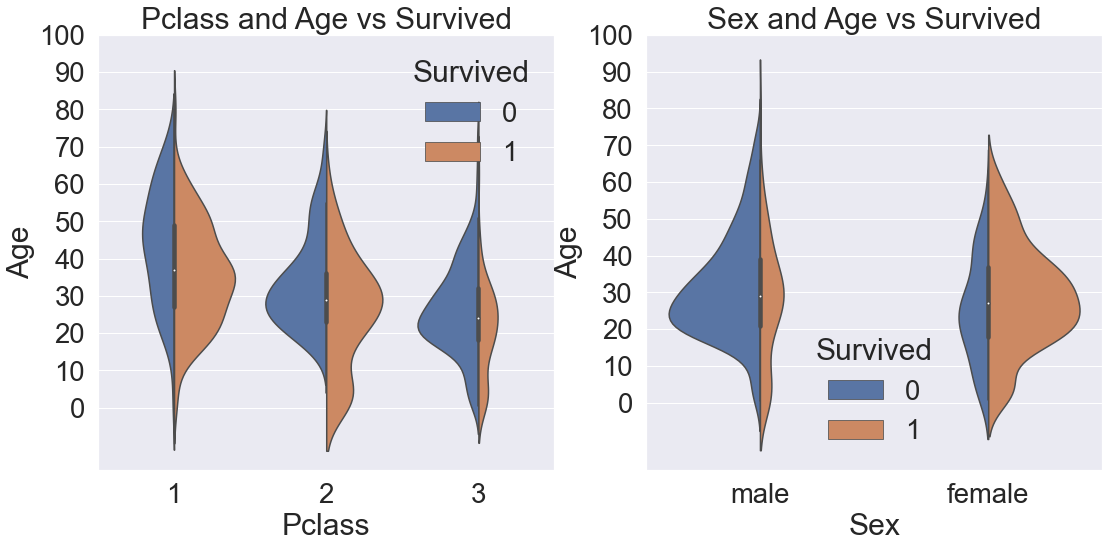

In [13]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
sns.violinplot('Pclass', 'Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot('Sex', 'Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

-> 왼쪽 그림은 Pclass 별로 Age의 distribution이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프이다. 오른쪽 그림은 Sex, 생존에 따른 distribution이 어떻게 다른지 보여주는 그래프이다.   
-> 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한 것을 볼 수 있다.            
-> 성별로는 여성이 생존을 많이 한 것을 볼 수 있다.

### 2.6 Embarked
---
- Embarked는 탑승한 항구를 나타낸다.
- 위에서 해왔던 것과 비슷하게 탑승한 곳에 따른 생존률을 보겠다.


<AxesSubplot:xlabel='Embarked'>

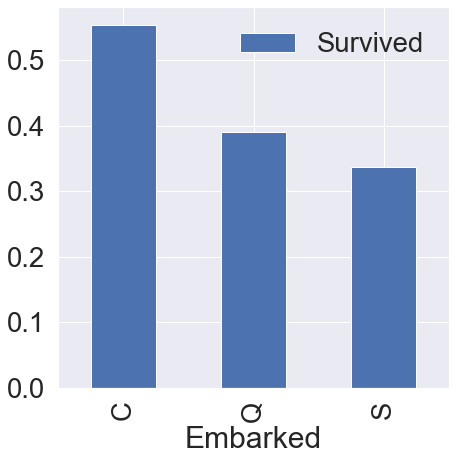

In [14]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

-> 조금 차이는 있지만 생존률은 좀 비슷한 편이다. 그래도 C가 제일 높다.    
=> 모델에 얼마나 큰 영향을 미칠지는 모르겠지만 그래도 사용하기로 하겠다.         
=> 사실 모델을 만들고 나면 우리가 사용한 feature들이 얼마나 중요한 역할을 했는지 확인해볼 수 있다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것이다.

- 다른 feature로 split하여 한번 살펴보겠다.

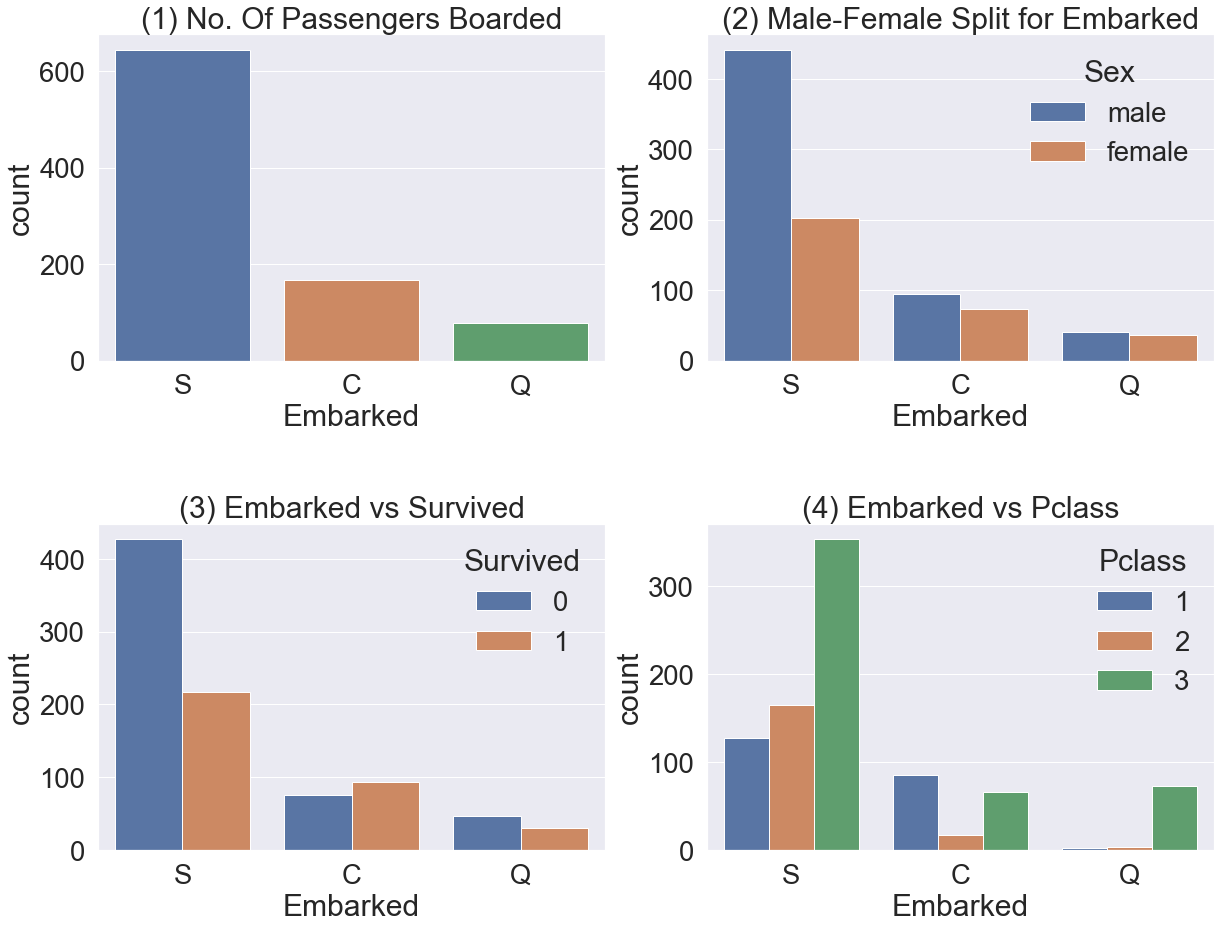

In [16]:
f, ax = plt.subplots(2, 2, figsize=(20,15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

-> Figure(1) - 전체적으로 봤을 때 S에서 가장 많은 사람이 탑승했다.          
-> Figure(2) - C와 Q의 남녀 비율이 비슷하고, S는 남성이 더 많다.              
-> Figure(3) - 생존확률이 S의 경우 많이 낮은 것을 볼 수 있다.               
-> Figure(4) - Class로 split 해서 보니 C가 생존확률이 높은건 클래스가 높은 사람 많이 타서 그렇다. S는 3rd Class가 많아서 생존 확률이 낮게 나온다.

### 2.7 Family - SibSp(형제자매) + Parch(부모, 자녀) 
---
- SibSp과 Parch를 합하면 Family가 된다. Family로 합쳐서 분석해보자.

In [17]:
df_train.FamilySize = df_train.SibSp + df_train.Parch + 1 # 자신도 포함해야되니 1 더함
df_test.FamilySize = df_test.SibSp + df_test.Parch + 1

In [18]:
print('Maximum size of Family: ', df_train.FamilySize.max())
print('Minimum size of Family: ', df_train.FamilySize.min())

Maximum size of Family:  11
Minimum size of Family:  1


- FamilySize와 Survived의 관계 살펴보기

ValueError: Could not interpret input 'FamilySize'

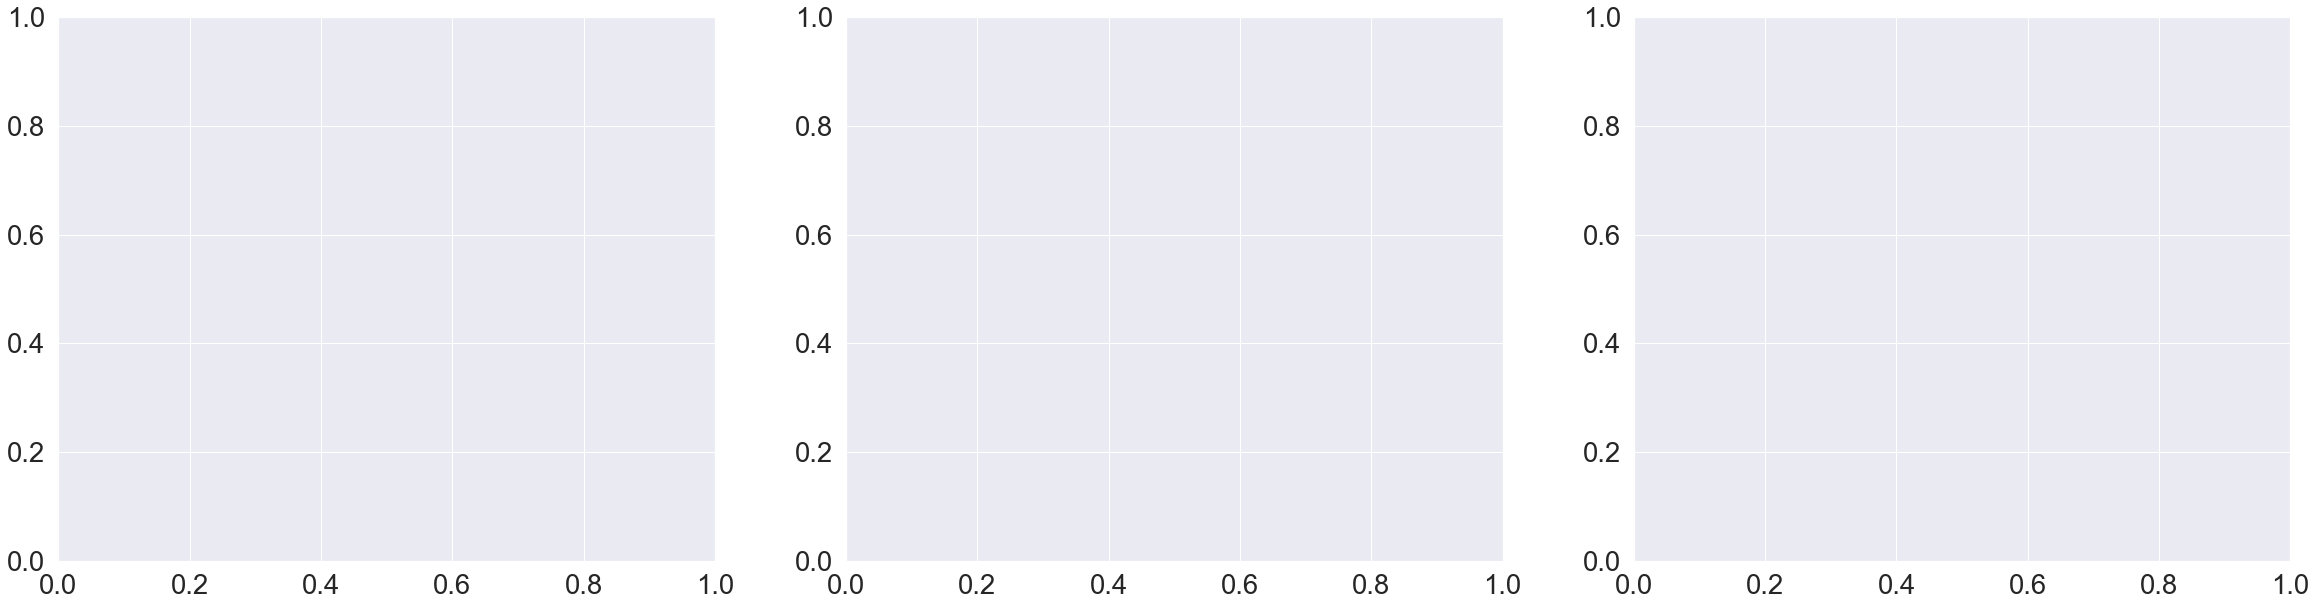

In [24]:
f,ax=plt.subplots(1, 3, figsize=(40,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',  y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize',  y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

-> Figure(1): 가족크기가 1~11까지 있음을 볼 수 있다. 대부분 1명이고 그 다음으로 2, 3, 4명이다.      

-> Figure(2), (3): 가족 크기에 다른 생존비교이다. 가족이 4명인 경우가 가장 생존 확률이 높다. 가족수가 많아질수록 생존확률이 낮아진다. 가족수가 너무 작아도(1) 너무 커도(5, 6, 8, 11) 생존 확률이 작다. 3~4명 선에서 생존확률이 높은 걸 확인할 수 있다.


### 2.8 Fare
---
- Fare는 탑승요금이며, coutinous feature이다. 한번 histogram 을 그려보겠다.


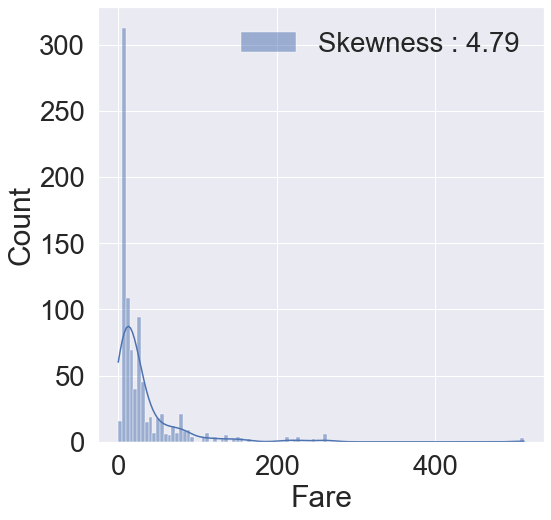

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
g = sns.histplot(df_train.Fare, kde=True, color='b', label='Skewness : {:.2f}'.format(df_train.Fare.skew()), ax=ax)
g = g.legend(loc='best')

-> 보다시피 distribution이 매우 비대칭이다.(high skewness) 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못 학습할 수도 있다. 몇개 없는 outlier에 대해서 너무 민감하게 반응한다며 실제 예측 시에 좋지 못한 결과를 부를 수 있다.                     
-> outlier의 영향을 줄이기 위해 Fare에 log를 취하겠다.
- 여기서 우리는 pandas의 유용한 기능을 사용할 것이다. **dataframe의 특정 columns에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply를 사용하면 매우 손쉽게 적용할 수 있다.**
- 우리가 지금 원하는 것은 Fare columns의 데이터 모두를 log값 취하는 것인데, 파이썬의 간단한 lambda 함수를 이용해 간단한 로그를 적용하는 함수를 map에 인수로 넣어주면, Fare columns 데이터에 그대로 적용이 된다. 매우 유용한 기능이니 꼭 숙지하자!! 

In [32]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test.Fare.mean()
# test set에 있는 nan value를 평균값을 치환한다.

df_train.Fare = df_train.Fare.map(lambda i: np.log(i) if i > 0 else 0)
df_test.Fare = df_test.Fare.map(lambda i: np.log(i) if i > 0 else 0)

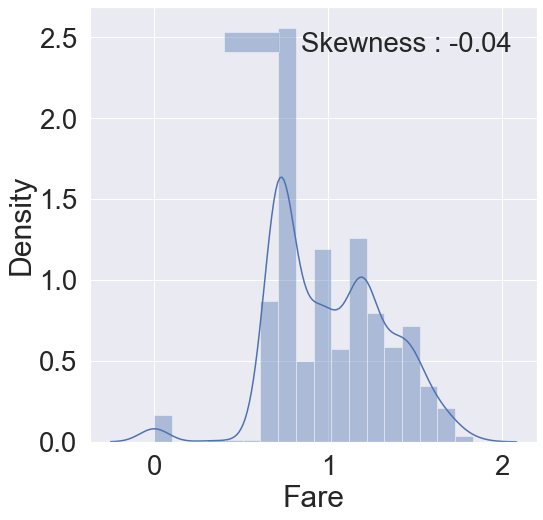

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
g = sns.distplot(df_train.Fare, color='b', label='Skewness : {:.2f}'.format(df_train.Fare.skew()), ax=ax)
g = g.legend(loc='best')

-> log 를 취하니 이제 비대칭성이 많이 사라진 것을 볼 수 있다.     
- 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있다. 
- 방금 작업한 것은 feature engineering 에 들어가는 부분인데 여기서 작업했다.
- 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature들에 여러 조작을 가하거나, 새로운 feature을 추가하는 것을 feature engineering 이라고 하는데 우리는 이제 그것을 살펴볼 것이다. 

### 2.9 Cabin
---
- 이 feature는 NaN이 대략 80%이므로 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지는 않다
=> 모델에 포함시키지 않도록 하겠다.

In [34]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0.683603,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1.450832,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,0.727559,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1.379314,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,0.735091,NaN,S


### 2.10 Ticket
---
- 이 feature 는 NaN이 없다. 일단 string data이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해선 아이디어가 필요하다.

In [35]:
df_train.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

-> ticket number은 매우 다양하다.                 
-> 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까?